# Benchmark paper experiments 

Code for generating the pictures and graphs for the paper "Waterberry Farms: a realistic benchmark for multi-robot informative path planning". It illustrates various ways of running a __one day__ experiment on a __static environment__ with a __single robot__.

The experiments in this notebook illustrate differences between different estimator/path planner pairs. The path planners are simple static examples (lawnmower, spiral, random waypoint) and they are not intended to be state of the art. 

In [1]:
# allow imports from the main source directory
import sys
sys.path.append('..')
import logging
logging.basicConfig(level=logging.WARNING)

import pathlib

import pickle
import gzip as compress
import copy
import matplotlib.pyplot as plt
import matplotlib.lines as lines
# configuring the fonts such that no Type 3 fonts are used
# requirement for ICRA
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["figure.autolayout"] = True

import numpy as np
import timeit
import warnings

from InformationModel import StoredObservationIM
from WaterberryFarm import create_wbfe, WaterberryFarm, MiniberryFarm, WBF_IM_DiskEstimator, WBF_IM_GaussianProcess, WBF_Score_WeightedAsymmetric, get_datadir
from WbfExperiment import action_run_oneday, action_precompute_environment, get_geometry, graph_env_im, graph_scores
from Policy import FollowPathPolicy, RandomWaypointPolicy
from PathGenerators import find_fixed_budget_spiral, generate_lawnmower, find_fixed_budget_lawnmower, generate_spiral_path, find_fixed_budget_spiral

logging.getLogger().setLevel(logging.WARNING)

# all the experiments results etc. should go into this directory
benchmark_dir = pathlib.Path(get_datadir(), "Benchmark-Paper")
benchmark_dir.mkdir(exist_ok=True)

# Precompute environments
* Precompute the evaluation of the environments. This allows the following simulations to run faster and to use the same environment for different path planning algorithms. 
* The precomputed data is saved into the corresponding directory under __Temporary/2022-01-15-MREM_data. __Delete that directory if you want to run the simulation with a differently parameterized environments.__
* This precalculates 50 days of evolution for all four environments. This is sufficient for the standard benchmark settings. 
* As this simulation is expensive for the large environments, be patient, it takes about __30 minutes__ on a fast machine. 


In [2]:
precompute = 50
# typenames = ["Miniberry-10", "Miniberry-30", "Miniberry-100", "Waterberry"]
typenames = ["Miniberry-10","Miniberry-30", "Miniberry-100"]
time_start_environment = 6

# typenames = ["Waterberry"]
# typenames = ["Miniberry-100"]
for typename in typenames:
    action_precompute_environment({"geometry": typename, "precompute-time": precompute})

# Generate pictures of the geometry. 
Generates pictures for the geometry of the various benchmark configurations (Miniberry-10,30,100 and Waterberry), and saves them into files $data/geometry_Miniberry-10.pdf etc.

FIXME: This could have been implemented with action load-environment

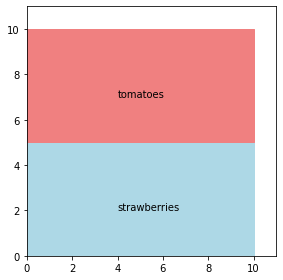

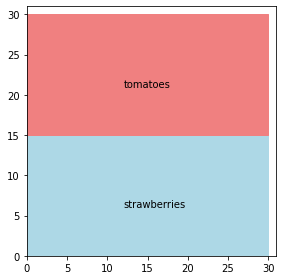

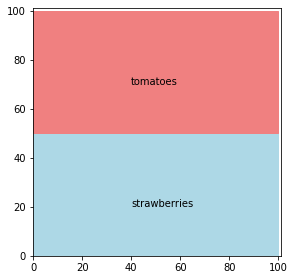

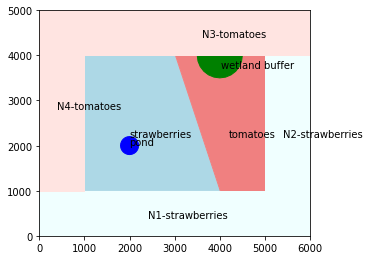

In [3]:
timepoints = [1, 3, 5, 10]
# typename = "Miniberry-10"

typenames_1 = ["Miniberry-10", "Miniberry-30", "Miniberry-100", "Waterberry"]
for typename in typenames_1:
    _, wbfe, _ = create_wbfe(saved = True, wbf_prec = None, typename = typename)
    geom = wbfe.geometry
    fig, ax = plt.subplots(1, figsize=(5,4))
    wbfe.geometry.visualize(ax)
    fig.tight_layout()
    plt.savefig(pathlib.Path(benchmark_dir, f"geometry_{typename}.pdf"))
    plt.savefig(pathlib.Path(benchmark_dir, f"geometry_{typename}.jpg"))

# End-of-day graphs
Helper functions for the visualization of the important aspects of a single day experiment.

In [6]:
def end_of_day_graphs(results, graphfilename = "EndOfDayGraph.pdf", title = None):
    """From the results of a 1 day experiment, create a figure that shows the
    environment, the information model at the end of the scenario, the path of the robot and the evolution of the score"""
    #print(results)
    wbfe = results["wbfe"]
    wbfim = results["estimator-code"]
    fig, ((ax_robot_path, ax_env_tylcv, ax_im_tylcv, ax_env_ccr, ax_im_ccr,
    ax_env_soil, ax_im_soil, ax_scores)) = plt.subplots(1, 8, figsize=(18,3))
    if title is None:
        fig.suptitle(f"{results['policy-name']}-{results['estimator-name']}", fontsize=16)
    elif title != "":
        fig.suptitle(title, fontsize=16)

    # visualize the observations, which gives us the path of the robot
    empty = np.ones_like(wbfe.tylcv.value.T)
    image_env_tylcv = ax_robot_path.imshow(empty, vmin=0, vmax=1, origin="lower", cmap="gray")    
    ax_robot_path.set_title("Robot path")

    obsx = []
    obsy = []
    for obs in results["observations"]:
        obsx.append(obs[StoredObservationIM.X])
        obsy.append(obs[StoredObservationIM.Y])
        old_obs = obs
    ax_robot_path.add_line(lines.Line2D(obsx, obsy, color="red"))

    graph_env_im(wbfe, wbfim, ax_env_tylcv=ax_env_tylcv, ax_im_tylcv=ax_im_tylcv, ax_env_ccr=ax_env_ccr, ax_im_ccr=ax_im_ccr, ax_env_soil=ax_env_soil, ax_im_soil=ax_im_soil, title_string="{label}")

    graph_scores(results, ax_scores)

    #ax_scores.plot(results["scores"])
    #ax_scores.set_ylim(top=0)
    #ax_scores.set_xlabel("Time")
    # ax_scores.set_ylabel("Score")
    #ax_scores.set_title("Scores")
    # fig.tight_layout()
    plt.savefig(pathlib.Path(benchmark_dir, graphfilename))


## Compare movement policies with the same estimator
Run one day experiments for comparing different policies with the same estimator. Visualize the results for each policy.

/home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Benchmark-Paper/res_Miniberry-30_1M_RandomWaypoint-Seed0
/home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Benchmark-Paper/res_Miniberry-30_1M_FixedBudgetLawnmower
/home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Benchmark-Paper/res_Miniberry-30_1M_AdaptiveLawnMower
/home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Benchmark-Paper/res_Miniberry-30_1M_Spiral


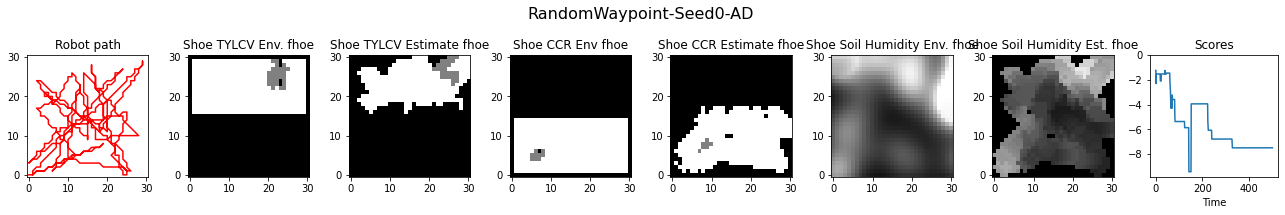

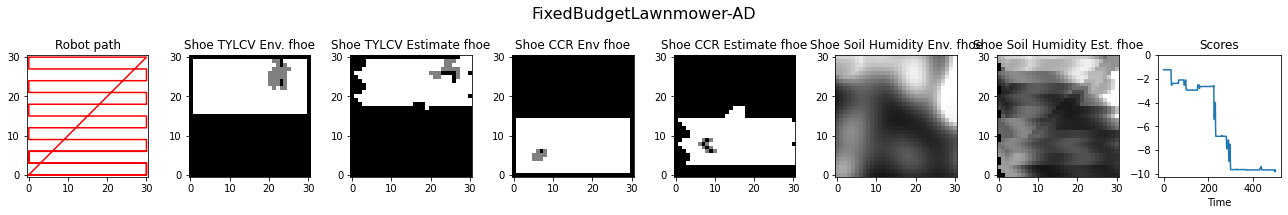

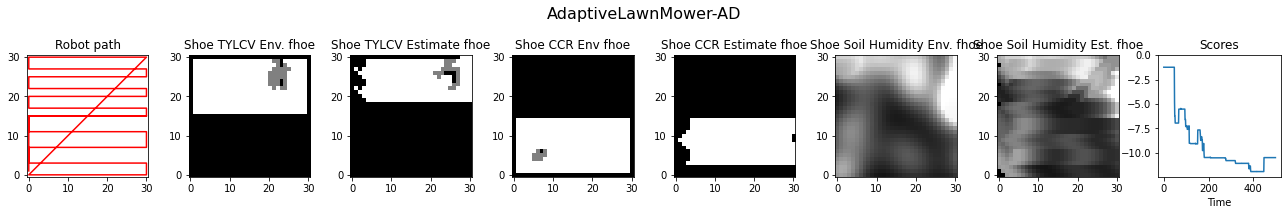

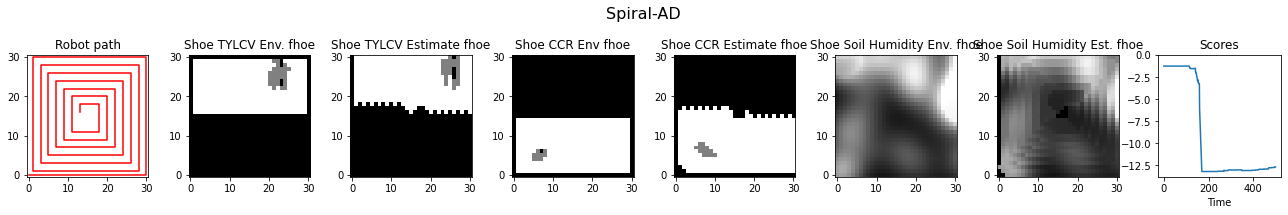

In [7]:
default_choices = {"geometry": "Miniberry-30", "action": "run", "scenario": "one-day-single-value", "visualize": 0,  "result-basedir": benchmark_dir}
default_choices["velocity"] = 1
default_choices["timesteps-per-day-override"] = 500 # 1000
default_choices["time-start-environment"] = 6

# if force_run is false, we do not re-run an already run policy 
force_run = False
policies = []

# a random waypoint policy
geo = get_geometry(default_choices["geometry"])
policy = RandomWaypointPolicy(vel = 1, low_point = [geo["xmin"], geo["ymin"]], high_point = [geo["xmax"], geo["ymax"]], seed = 0)  
policy.name = "RandomWaypoint-Seed0"
policies.append(policy)

 # a lawnmower policy that covers the target area in one day uniformly
geo = get_geometry(default_choices["geometry"])
path = find_fixed_budget_lawnmower([0,0], geo["xmin"], geo["xmax"], geo["ymin"], geo["ymax"], geo["velocity"], time = geo["timesteps-per-day"])
policy = FollowPathPolicy(vel = geo["velocity"], waypoints = path, repeat = True)
policy.name = "FixedBudgetLawnmower"
policies.append(policy)

# a lawnmower policy that covers the tomatoes more densely than the strawberries
geo = get_geometry(default_choices["geometry"])
height = geo["ymax"] - geo["ymin"]
time = float(geo["timesteps-per-day"])
## FIXME: this has to search for a plan that can be executed in the time
time_safety = time / 10.0
time_strawberry = time / 3.0 - time_safety
time_tomato = time - time_strawberry - time_safety
path1 = find_fixed_budget_lawnmower([0, 0], geo["xmin"], geo["xmax"], geo["ymin"] + height//2, geo["ymin"] + height, geo["velocity"], time_tomato)
path2 = find_fixed_budget_lawnmower(path1[-1], geo["xmin"], geo["xmax"], geo["ymin"], geo["ymin"] + height // 2, geo["velocity"], time_strawberry)
# second path is supposed to start from the last of first
path = np.append(path1, path2, axis=0)           
policy = FollowPathPolicy(vel = geo["velocity"], waypoints = path, repeat = True)            
policy.name = "AdaptiveLawnMower"
policies.append(policy)

# a spiral policy 
geo = get_geometry(default_choices["geometry"])
path = find_fixed_budget_spiral([0,0], x_min = geo["xmin"], x_max = geo["xmax"], y_min = geo["ymin"], y_max = geo["ymax"], velocity = geo["velocity"], time = geo["timesteps-per-day"])
policy = FollowPathPolicy(vel = geo["velocity"], waypoints = path, repeat = True) 
policy.name = "Spiral"    
policies.append(policy)

for policy in policies:
    # do a dryrun, to get the path to the cached values
    choices = copy.copy(default_choices)
    choices["policy-code"] = policy
    choices["policy-name"] = policy.name
    choices["dryrun"] = True
    choices["estimator-name"] = "AD"
    choices["estimator-code"] = WBF_IM_DiskEstimator(geo["width"], geo["height"])
    choices["score-code"] = WBF_Score_WeightedAsymmetric()

    results = action_run_oneday(choices)
    path = results["results-path"]
    print(path)
    # avoid re-running experiments
    if not path.exists() or force_run:
        choices["dryrun"] = False
        results = action_run_oneday(choices)
    else:
        with compress.open(path, "rb") as f:
            results = pickle.load(f)
    end_of_day_graphs(results, f"daily-summary-{results['policy-name']}-{results['estimator-name']}.pdf")

## Compare estimators in experiments
Run experiments to compare the estimators - the adaptive disk (AD) vs the Gaussian Process (GP). The Gaussian process is much slower, so it will take a quite longer time.

/home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Benchmark-Paper/res_Miniberry-30_1M_RandomWaypoint-Seed0-AD
/home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Benchmark-Paper/res_Miniberry-30_1M_RandomWaypoint-Seed0-GP
/home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Benchmark-Paper/res_Miniberry-30_1M_RandomWaypoint-Seed0-DE-10


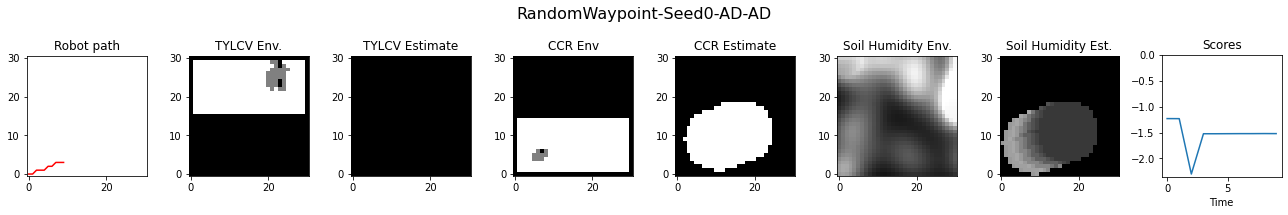

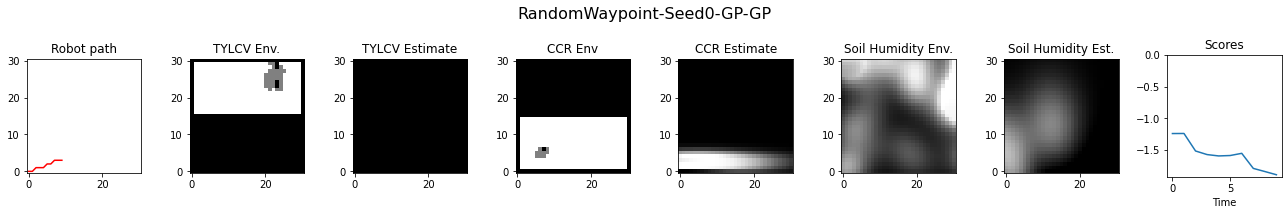

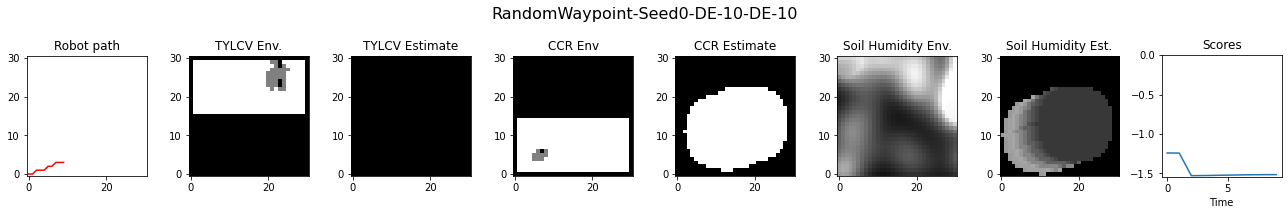

In [6]:


default_choices = {"geometry": "Miniberry-30", "action": "run", "scenario": "one-day-single-value", "visualize": 0,  "result-basedir": benchmark_dir}
default_choices["velocity-override"] = 1
default_choices["timesteps-per-day-override"] = 10
# 500 # will be 500, was 1000
default_choices["time-start-environment"] = 6
# cleaning up the warnings from the GP estimator
# logging.getLogger().setLevel(logging.ERROR)
warnings.simplefilter("ignore")
#warnings.filterwarnings(warnings.Warning, "ignore")

# if force_run is false, we do not re-run an already run policy 
force_run = False
for estimator in ["AD", "GP", "DE-10"]:
# for estimator in ["GP"]:
    # do a dryrun, to get the path to the cached values
    choices = copy.copy(default_choices)
    choices["dryrun"] = True

    geo = get_geometry(default_choices["geometry"])
    policy = RandomWaypointPolicy(vel = 1, low_point = [geo["xmin"], geo["ymin"]], high_point = [geo["xmax"], geo["ymax"]], seed = 0)  
    policy.name = "RandomWaypoint-Seed0"
    choices["policy-code"] = policy
    choices["policy-name"] = f"{policy.name}-{estimator}"
    choices["score-code"] = WBF_Score_WeightedAsymmetric()

    if estimator == "AD":
        choices["estimator-name"]  = "AD"
        choices["estimator-code"] = WBF_IM_DiskEstimator(geo["width"], geo["height"])
    elif estimator == "GP":
        choices["estimator-name"]  = "GP"
        choices["estimator-code"] = WBF_IM_GaussianProcess(geo["width"], geo["height"])        
    elif estimator == "DE-10":
        choices["estimator-name"]  = "DE-10"
        choices["estimator-code"] = WBF_IM_DiskEstimator(geo["width"], geo["height"], disk_radius=10)        

    results = action_run_oneday(choices)
    path = results["results-path"]
    print(path)
    # avoid re-running experiments
    if not path.exists() or force_run:
        choices["dryrun"] = False
        results = action_run_oneday(choices)
    else:
        with compress.open(path, "rb") as f:
            results = pickle.load(f)
    end_of_day_graphs(results, f"daily-summary-{results['policy-name']}.pdf")

## Compare the performance of various combinations of path planner and estimator

/home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Benchmark-Paper/res_Miniberry-30_1M_RandomWaypoint-Seed0
/home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Benchmark-Paper/res_Miniberry-30_1M_RandomWaypoint-Seed0-DE-10
/home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Benchmark-Paper/res_Miniberry-30_1M_FixedBudgetLawnmower
/home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Benchmark-Paper/res_Miniberry-30_1M_random-only-strawberry
/home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Benchmark-Paper/res_Miniberry-30_1M_RandomWaypoint-Seed0-AD
/home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Benchmark-Paper/res_Miniberry-30_1M_random-default
/home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Benchmark-Paper/res_Miniberry-30_1M_random-only-tomato
/home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Benchmark-Paper/res_Miniberry-30_1M_RandomWayp

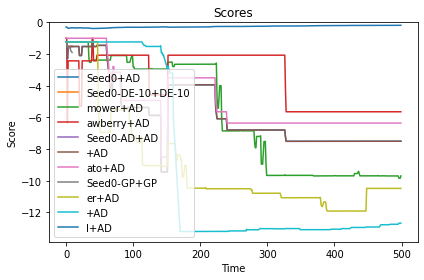

In [7]:
# gather all the results. As I am reading them in, generate the graphs.
allresults = []
for a in benchmark_dir.iterdir():
    if a.name.startswith("res_"):
        print(a)
        with compress.open(a, "rb") as f:
            results = pickle.load(f)
            allresults.append(results)

fig, ax_scores = plt.subplots(1, figsize=(6,4))
for results in allresults:
    ax_scores.plot(results["scores"], label = f'{results["policy-name"][len("benchmarkpaper-"):]}+{results["estimator-name"]}')
ax_scores.set_ylim(top=0)
ax_scores.set_xlabel("Time")
ax_scores.set_ylabel("Score")
ax_scores.set_title("Scores")
ax_scores.legend()
fig.tight_layout()


## Compare the results of different score functions
Verifying that different scoring functions are called

/home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Benchmark-Paper/res_Miniberry-30_1M_random-default
/home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Benchmark-Paper/res_Miniberry-30_1M_random-only-strawberry
/home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Benchmark-Paper/res_Miniberry-30_1M_random-only-tomato
/home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Benchmark-Paper/res_Miniberry-30_1M_random-only-soil


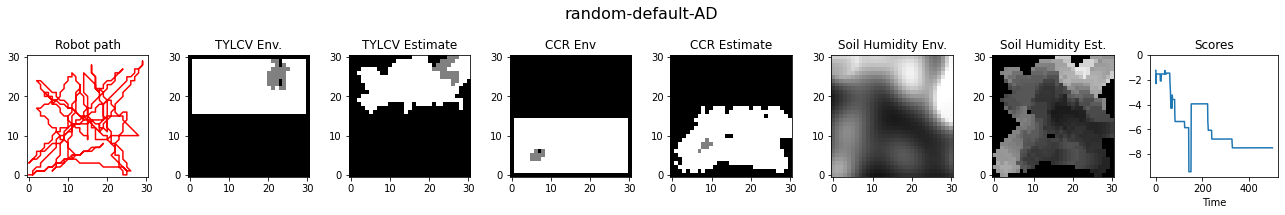

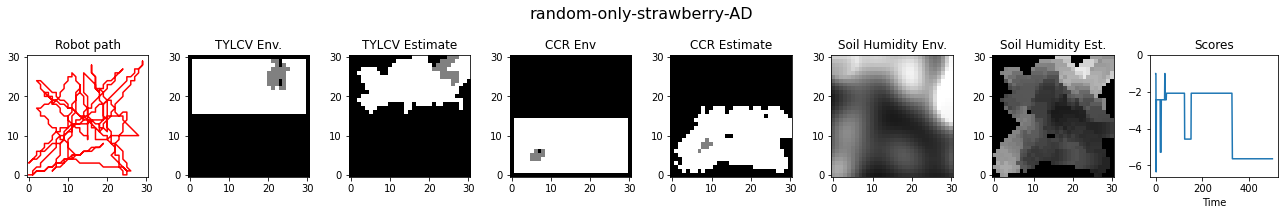

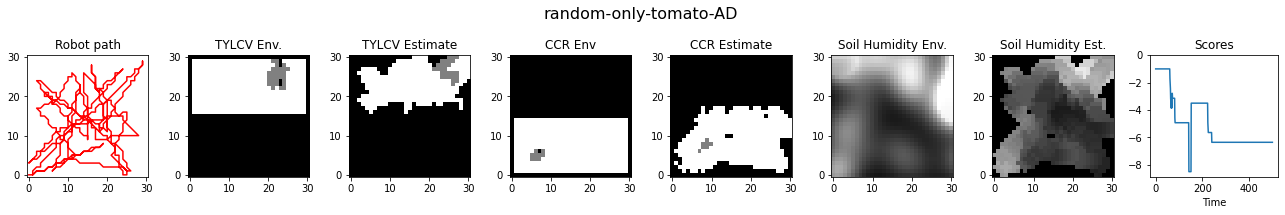

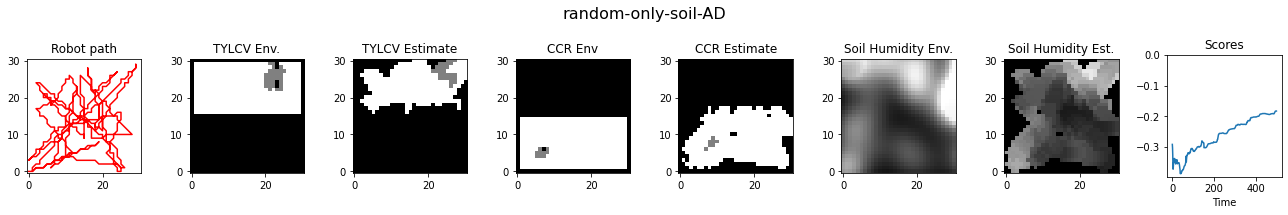

In [8]:
default_choices = {"geometry": "Miniberry-30", "action": "run", "scenario": "one-day-single-value", "visualize": 0,  "result-basedir": benchmark_dir}
default_choices["velocity"] = 1
default_choices["timesteps-per-day-override"] = 500 # 1000
default_choices["time-start-environment"] = 6

# a random waypoint policy
geo = get_geometry(default_choices["geometry"])
policy = RandomWaypointPolicy(vel = 1, low_point = [geo["xmin"], geo["ymin"]], high_point = [geo["xmax"], geo["ymax"]], seed = 0)  

# create a set of score functions
scores = {}
scores["default"] = WBF_Score_WeightedAsymmetric()
scores["only-strawberry"] = WBF_Score_WeightedAsymmetric(strawberry_importance=1.0, strawberry_negative_importance=10.0, tomato_importance=0.0, tomato_negative_importance=10.0, soil_importance=0.0)
scores["only-tomato"] = WBF_Score_WeightedAsymmetric(strawberry_importance=0.0, strawberry_negative_importance=10.0, tomato_importance=1.0, tomato_negative_importance=10.0, soil_importance=0.0)
scores["only-soil"] = WBF_Score_WeightedAsymmetric(strawberry_importance=0.0, strawberry_negative_importance=10.0, tomato_importance=0.0, tomato_negative_importance=10.0, soil_importance=1.0)

for scorename, scorecode in scores.items():
    # do a dryrun, to get the path to the cached values
    choices = copy.copy(default_choices)
    choices["policy-code"] = policy
    choices["policy-name"] = f"random-{scorename}"
    choices["estimator-name"] = "AD"
    choices["estimator-code"] = WBF_IM_DiskEstimator(geo["width"], geo["height"])
    choices["score-code"] = scorecode

    choices["dryrun"] = True
    results = action_run_oneday(choices)
    path = results["results-path"]
    print(path)
    # avoid re-running experiments
    if not path.exists() or force_run:
        choices["dryrun"] = False
        results = action_run_oneday(choices)
    else:
        with compress.open(path, "rb") as f:
            results = pickle.load(f)
    end_of_day_graphs(results, f"daily-summary-{results['policy-name']}-{results['estimator-name']}.pdf")

# Comparing the computational cost of different estimators
This code calculates the computational cost for different estimators (current GP and adaptive disk). This code takes about 10 min to run. 

In [11]:
from logging import getLogger

logging.getLogger().setLevel(logging.INFO)
warnings.simplefilter("ignore")

typenames = ["Miniberry-10", "Miniberry-30", "Miniberry-100", "Waterberry"]

file = pathlib.Path(benchmark_dir, "timecomp")
totaltime = 500 # the time we extend if 
timestep = 10 # at what timesteps we do a measurement
stop_at = 10.0 # if a single estimate takes longer than this, we stop

if file.exists():
    with open(file, "rb") as f:
        res = pickle.load(f)
else:
    res = {}
    for estimator in ["AD", "GP"]:
        for typename in typenames:
            # break out, as GP Waterberry 10 is 160 seconds
            if estimator == "GP" and typename == "Waterberry":
                break
            wbf, wbfe, _ = create_wbfe(saved = True, wbf_prec = None, typename = typename)
            wbfe.proceed(time_start_environment)
            if estimator == "GP":
                wbfim = WBF_IM_DiskEstimator(wbf.width, wbf.height)
            else: 
                wbfim = WBF_IM_GaussianProcess(wbf.width, wbf.height)
            ## create some observations and add them...
            times = []
            ts = []
            t = 0
            while t < totaltime:
                for obs in range(timestep):
                    t = t + 1
                    x = np.random.random_integers(wbf.width-1)
                    y = np.random.random_integers(wbf.height-1)
                    position = [x, y, t] # fixme random position
                    obs = wbfe.get_observation(position)
                    wbfim.add_observation(obs)
                ## measure the time it takes here
                time = timeit.timeit("wbfim.proceed(1)", number=1,  globals=globals())
                getLogger().info(f"{t} = {time} {estimator} {typename}")
                if time > stop_at:
                    break
                times.append(time)
                ts.append(t)
            res[f"{typename}_{estimator}"] = [ts, times]
    with open(file, "wb") as f:
        pickle.dump(res, f)

INFO:root:loading the geometry and environment from saved data
INFO:root:loading done
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 6
INFO:root:Loading from gz /home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Miniberry-10/precalc_tylcv/env_value_00006.gz
INFO:root:Loading from gz /home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Miniberry-10/precalc_tylcv/env_value_00006.gz done
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 6
INFO:root:Loading from gz /home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Miniberry-10/precalc_ccr/env_value_00006.gz
INFO:root:Loading from gz /home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Miniberry-10/precalc_ccr/env_value_00006.gz done
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Pr

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 39 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'D', 'G', 'M', 'O', 'P', 'T', 'W', 'a', 'b', 'c', 'd', 'e', 'eight', 'five', 'four', 'hyphen', 'i', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'underscore', 'v', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 36, 39, 42, 48, 50, 51, 55, 58, 66, 68, 69, 70, 71, 72, 76, 80, 81, 82, 85, 86, 87, 89, 92]
INFO:fontTools.s

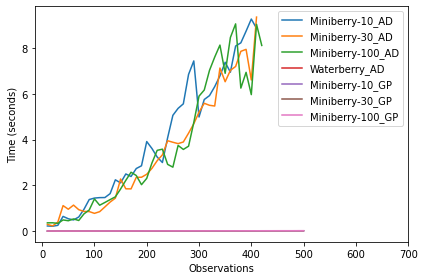

In [12]:

fig, ax = plt.subplots(1, 1, figsize=(6,4))

for key in res:
    ax.plot(res[key][0], res[key][1], label = key)
#ax.set_ylim(top=0)
ax.set_xlim(right=700)
ax.set_xlabel("Observations")
ax.set_ylabel("Time (seconds)")
#ax_scores.set_title("Scores")
ax.legend()
fig.tight_layout()
plt.savefig(pathlib.Path(benchmark_dir, "estimator_computational_cost.pdf"))


# Evolution of the environments at a list of specific timepoints

Generates figures for the state of the environment components at various timepoints. The default timepoints are the 1, 5, 10, 15 that are good for visualizing what goes on in the multiday experiments. 

The results are saved into $data/env-dynamics-{typename}-{value} files.

INFO:root:loading the geometry and environment from saved data
INFO:root:loading done
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:Loading from gz /home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Miniberry-10/precalc_tylcv/env_value_00001.gz
INFO:root:Loading from gz /home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Miniberry-10/precalc_tylcv/env_value_00001.gz done
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:PrecalculatedEnvironment at timestamp 1
INFO:root:Loading from gz /home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Miniberry-10/precalc_ccr/env_value_00001.gz
INFO:root:Loading from gz /home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/Miniberry-10/precalc_ccr/env_value_00001.gz done
INFO:root:Environment.proceed - calling the inner_proceed
INFO:root:Pr

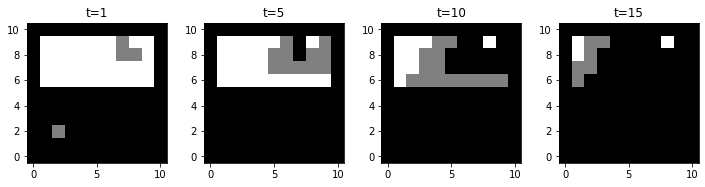

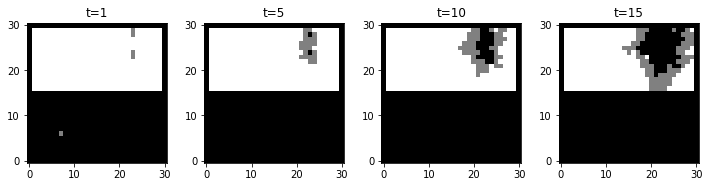

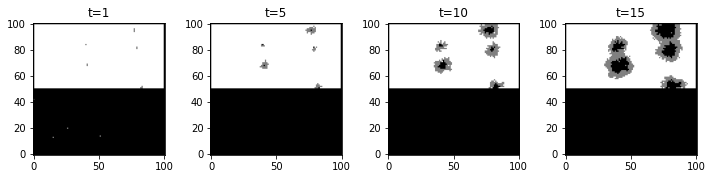

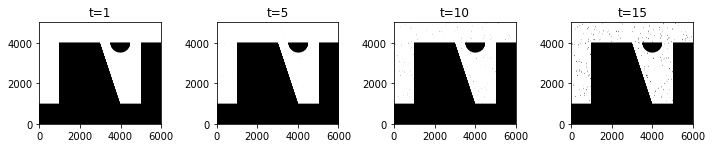

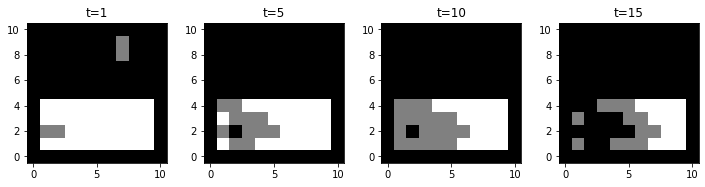

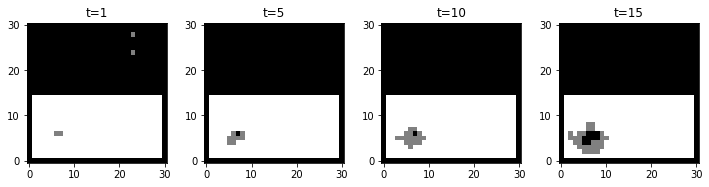

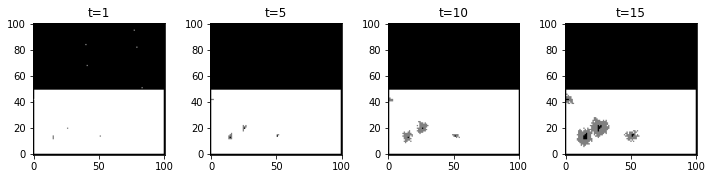

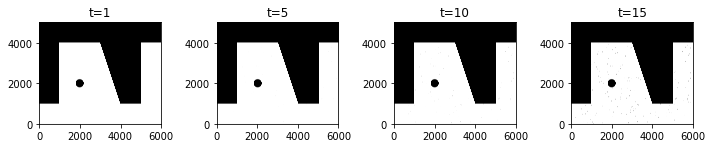

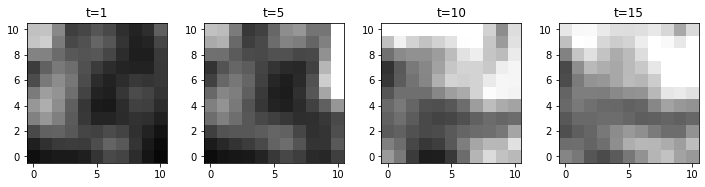

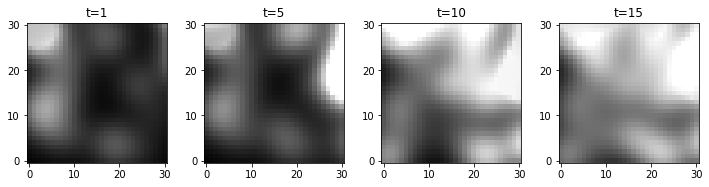

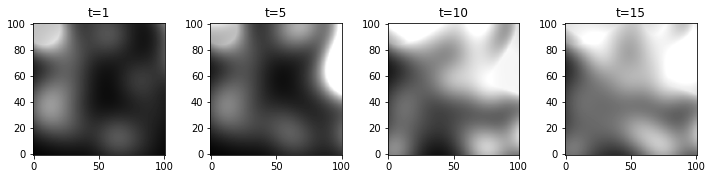

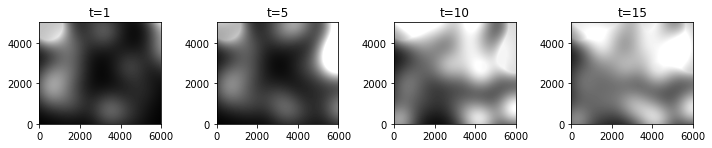

In [13]:
typenames = ["Miniberry-10", "Miniberry-30", "Miniberry-100", "Waterberry"]
#typenames = ["Miniberry-100"]
values = ["tylcv", "ccr", "soil"]
timepoints = [1, 5, 10, 15]

for value in values:
    for typename in typenames:
        _, wbfe, _ = create_wbfe(saved = True, wbf_prec = None, typename = typename)
        fig, axs = plt.subplots(1, len(timepoints), figsize = (2.5 * len(timepoints), 2.5))
        #fig.suptitle(f"{typename} / {value}")
        ntt = 0
        for t in range(timepoints[-1]+1):
            if t >= timepoints[ntt]:
                if value == "tylcv":
                    val = wbfe.tylcv.value
                elif value == "ccr":
                    val = wbfe.ccr.value
                elif value == "soil":
                    val = wbfe.soil.value
                axs[ntt].imshow(val.T, vmin=0, vmax=1, cmap="gray", origin="lower")
                axs[ntt].set_title(f"t={timepoints[ntt]}")
                ntt = ntt + 1
            wbfe.proceed()
        fig.tight_layout()
        plt.savefig(pathlib.Path(benchmark_dir, f"env-dynamics-{typename}-{value}.pdf"))
        plt.savefig(pathlib.Path(benchmark_dir, f"env-dynamics-{typename}-{value}.jpg"))

